In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

from CoExBO._utils import TensorManager
from CoExBO._coexbo import CoExBOwithSimulation, AlphaPIBOwithSimulation, CoTrustBOwithSimulation, StateManager
from CoExBO._prior import Uniform


tm = TensorManager()
warnings.filterwarnings('ignore')

c:\Users\mauri\miniconda3\envs\ExplainableBO\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Additional setup

In [13]:
import torch
import botorch.optim.initializers as _init_mod

# 1) Stash the original
_original_initialize_q_batch = _init_mod.initialize_q_batch

# 2) Define a safe wrapper
def _safe_initialize_q_batch(*args, **kwargs):
    # Try to find Y in kwargs
    if "Y" in kwargs:
        Y = kwargs["Y"]
        kwargs["Y"] = torch.nan_to_num(
            Y,
            nan=-1e6,
            neginf=-1e6,
            posinf=+1e6,
        )
        return _original_initialize_q_batch(*args, **kwargs)
    # Otherwise, look for Y as the second positional arg
    if len(args) >= 2:
        X, Y, *rest = args
        Y = torch.nan_to_num(
            Y,
            nan=-1e6,
            neginf=-1e6,
            posinf=+1e6,
        )
        new_args = (X, Y, *rest)
        return _original_initialize_q_batch(*new_args, **kwargs)
    # If we really got nothing, just forward through
    return _original_initialize_q_batch(*args, **kwargs)

# 3) Monkey‑patch it
_init_mod.initialize_q_batch = _safe_initialize_q_batch


In [14]:
import botorch.optim.optimize as _opt_mod
from CoExBO._dueling_acquisition_function import BaseDuelingAcquisitionFunction

# 1) Stash the original
_orig_optimize_function = BaseDuelingAcquisitionFunction.optimize_function

# 2) Patch it to disable analytic gradients
def _patched_optimize_function(self, acqf):
    X_next, _ = _opt_mod.optimize_acqf(
        acqf,
        bounds=self.bounds,
        q=1,
        num_restarts=self.n_restarts,
        raw_samples=self.raw_samples,
        options={"with_grad": False},  # <<— turn off grad
    )
    return self.cleansing_input(X_next)

# 3) Override the method
BaseDuelingAcquisitionFunction.optimize_function = _patched_optimize_function


# Synthetic Functions

In [2]:
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1).double()

def Ackley4Function(x, a=20.0, b=0.2, c=2 * math.pi):
    """
    Vectorized negated Ackley function for maximization.
    x: torch tensor of shape (..., 4)
    Returns: torch tensor of shape (...)
    """
    d = 4 #x.shape[-1]

    sum_sq = torch.sum(x**2, dim=-1) / d
    sum_cos = torch.sum(torch.cos(c * x), dim=-1) / d

    term1 = -a * torch.exp(-b * torch.sqrt(sum_sq))
    term2 = -torch.exp(sum_cos)
    f = term1 + term2 + a + math.e

    return -f.double()

def HolderTableFunction(x):
    """
    Torch-native vectorized negated Holder Table function for maximization.
    Input:
        x: torch.Tensor of shape (..., 2)
    Output:
        torch.Tensor of shape (...)
    """
    x = x.double()
    x1, x2 = x[..., 0], x[..., 1]
    r = torch.sqrt(x1**2 + x2**2)
    value = -torch.abs(torch.sin(x1) * torch.cos(x2) * torch.exp(torch.abs(1 - r / math.pi)))
    return -value.double()

def MichalewiczFunction(x, m=10):
    """
    Torch-native Michalewicz function (negated for maximization).
    Input: x (tensor of shape [..., d])
    Output: tensor of shape [...]
    """
    x = x.double()
    d = x.shape[-1]
    i = torch.arange(1, d + 1, dtype=x.dtype, device=x.device).view(1, -1)
    value = -torch.sum(torch.sin(x) * torch.sin(i * x**2 / math.pi)**(2 * m), dim=-1)
    return -value  # negate for maximization

def RosenbrockFunction(x):
    """
    Torch-native Rosenbrock function (negated for maximization).
    Input: x (tensor of shape [..., d])
    Output: tensor of shape [...]
    """
    x = x.double()
    value = torch.sum(100 * (x[..., 1:] - x[..., :-1]**2)**2 + (1 - x[..., :-1])**2, dim=-1)
    return -value  # negate for maximization

def Hartmann6Function(x):
    """
    Torch‑native 6D Hartmann function (maximization).
    Accepts:
        x: Tensor of shape (..., 6) or (6,)
    Returns:
        Tensor of shape (...) or scalar
    """
    # ensure double precision
    x = x.double()
    # flatten leading dims
    orig_shape = x.shape[:-1]
    x = x.reshape(-1, 6)  # now (N,6)

    # Hartmann6 constants
    alpha = torch.tensor([1.0, 1.2, 3.0, 3.2], dtype=x.dtype, device=x.device)        # (4,)
    A     = torch.tensor([
        [10.0,   3.0,  17.0, 3.5,  1.7, 8.0],
        [ 0.05, 10.0,  17.0, 0.1,  8.0,14.0],
        [ 3.0,   3.5,   1.7,10.0, 17.0, 8.0],
        [17.0,   8.0,   0.05,10.0, 0.1,14.0],
    ], dtype=x.dtype, device=x.device)                                                   # (4,6)
    P     = 1e-4 * torch.tensor([
        [1312, 1696, 5569,  124, 8283, 5886],
        [2329, 4135, 8307, 3736, 1004, 9991],
        [2348, 1451, 3522, 2883, 3047, 6650],
        [4047, 8828, 8732, 5743, 1091,  381],
    ], dtype=x.dtype, device=x.device)                                                   # (4,6)

    # compute (x[None,:,:] - P[:,None,:]) -> (4,N,6)
    diff2 = (x[None, :, :] - P[:, None, :]) ** 2     # (4, N, 6)
    inner = torch.sum(A[:, None, :] * diff2, dim=-1)  # (4, N)

    # weight and sum over the 4 terms → shape (N,)
    vals = torch.sum(alpha[:, None] * torch.exp(-inner), dim=0)  # (N,)

    # restore original leading shape
    return vals.reshape(orig_shape)

def StyblinskyFunction(x):
    """
    Torch-native Styblinski–Tang function (negated for maximization).
    Input: x (tensor of shape [..., d])
    Output: tensor of shape [...]
    """
    x = x.double()
    value = 0.5 * torch.sum(x**4 - 16 * x**2 + 5 * x, dim=-1)
    return -value 

In [3]:
# Assume all function definitions (e.g. ackley_4d, holder_table, etc.) are already defined

def define_function(function_name):
    global lower_limit, upper_limit, ground_truth, n_dims, bounds, domain, true_function, samples, true_max

    if function_name.lower() == "branin":
        lower_limit = -2
        upper_limit = 3
        ground_truth = torch.tensor([-1.02543108, -1.02543108])
        n_dims = 2

        mins = lower_limit * torch.ones(n_dims)
        maxs = upper_limit * torch.ones(n_dims)
        bounds = torch.vstack([mins, maxs])

        domain = Uniform(bounds)
        true_function = BraninFunction

    elif function_name.lower() == "ackley":
        lower_limit = -32.768
        upper_limit = 32.768
        ground_truth = torch.tensor([0.0, 0.0, 0.0, 0.0])
        n_dims = 4

        mins = lower_limit * torch.ones(n_dims)
        maxs = upper_limit * torch.ones(n_dims)
        bounds = torch.vstack([mins, maxs])

        domain = Uniform(bounds)
        true_function = Ackley4Function


    elif function_name.lower() == "holder":
        lower_limit = -10
        upper_limit = 10
        ground_truth = torch.tensor([8.05502, 9.66459])
        n_dims = 2

        mins = lower_limit * torch.ones(n_dims)
        maxs = upper_limit * torch.ones(n_dims)
        bounds = torch.vstack([mins, maxs])

        domain = Uniform(bounds)
        true_function = HolderTableFunction


    elif function_name.lower() == "michalewicz":
        lower_limit = 0
        upper_limit = np.pi
        n_dims = 5
        ground_truth = torch.tensor([2.20, 1.57, 1.29, 1.40, 1.52])  # example near-optimum

        mins = lower_limit * torch.ones(n_dims)
        maxs = upper_limit * torch.ones(n_dims)
        bounds = torch.vstack([mins, maxs])

        domain = Uniform(bounds)
        true_function = MichalewiczFunction


    elif function_name.lower() == "rosenbrock":
        lower_limit = -5
        upper_limit = 10
        n_dims = 3
        ground_truth = torch.ones(n_dims)
        
        mins = lower_limit * torch.ones(n_dims)
        maxs = upper_limit * torch.ones(n_dims)
        bounds = torch.vstack([mins, maxs])

        domain = Uniform(bounds)
        true_function = RosenbrockFunction


    elif function_name.lower() == "hartmann":
        lower_limit = 0
        upper_limit = 1
        n_dims = 6
        ground_truth = torch.tensor([0.20169, 0.15001, 0.47687, 0.27533, 0.31165, 0.6573])

        mins = lower_limit * torch.ones(n_dims)
        maxs = upper_limit * torch.ones(n_dims)
        bounds = torch.vstack([mins, maxs])

        domain = Uniform(bounds)
        true_function = Hartmann6Function


    elif function_name.lower() == "styblinski-tang":
        lower_limit = -5
        upper_limit = 5
        n_dims = 4
        ground_truth = torch.full((n_dims,), -2.903534)

        mins = lower_limit * torch.ones(n_dims)
        maxs = upper_limit * torch.ones(n_dims)
        bounds = torch.vstack([mins, maxs])

        domain = Uniform(bounds)
        true_function = StyblinskyFunction


    else:
        raise ValueError(f"Unknown function: {function_name}")

    true_max = true_function(ground_truth.unsqueeze(0)).view(-1)
    # Sample the domain
    samples = domain.sample(1000)


# Setup

In [4]:
colour_map = 'summer'
resolution = 200
n_init_pref = 100      # number of initial random samples for preferential learning
n_init_obj = 20        # number of initial random samples for objective function
def compute_regret(dataset_obj, true_optimum_value):
    best_observed = dataset_obj[1].max().item()
    return abs(true_optimum_value - best_observed)

# CoExBO

In [5]:
def CoExBO(function_name):

    sigma = 0.1
    n_iterations = 100     # number of iterations
    n_reps = 3             # number of repetitions
    seed = 0
    base_seed = 0           # base seed for reproducibility
    log_regrets = np.zeros((n_reps, n_iterations))
    torch.manual_seed(seed)
    experiment_name =  f'CoExBO_{function_name}'

    for i in range(n_reps):
        print(f"Starting repetition {i+1}/{n_reps}")
        
        # Set a different seed for each repetition for variability
        torch.manual_seed(base_seed + i)
        np.random.seed(base_seed + i)

        coexbo = CoExBOwithSimulation(domain, true_function, sigma=sigma)
        dataset_obj, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)

        state = StateManager(n_dims=n_dims)
        results = []

        for t in range(n_iterations):
            beta, gamma = state(t)
            result, dataset_obj, dataset_duel = coexbo(
                dataset_obj, dataset_duel, beta, gamma,
            )
            print(f"[Rep {i+1}] {len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
            results.append(result)

            regret = compute_regret(dataset_obj, true_max)
            log_regrets[i, t] = np.log10(regret + 1e-8)  # avoid log(0)

    # Save all repetitions
    np.savez(experiment_name, log_regrets=log_regrets)

# AlphaPiBO

In [6]:
def AlphaPiBO(function_name):

    alpha = 0.5
    n_iterations = 100     # number of iterations
    n_reps = 3            # number of repetitions
    base_seed = 0          # for reproducibility
    log_regrets = np.zeros((n_reps, n_iterations))
    # initial setting
    torch.manual_seed(base_seed)
    experiment_name = f'AlphaPiBO_{function_name}.npz'

    for i in range(n_reps):
        print(f"Starting repetition {i+1}/{n_reps}")
        
        # Set reproducible seed for each run
        torch.manual_seed(base_seed + i)
        np.random.seed(base_seed + i)

        # Initial setup per repetition
        alphapibo = AlphaPIBOwithSimulation(domain, true_function, 
                                    sigma=alpha, uncertain_prior=True)
        dataset_obj, dataset_duel = alphapibo.initial_sampling(n_init_obj, n_init_pref)
        state = StateManager(n_dims=n_dims)
        results = []

        for t in range(n_iterations):
            beta, gamma = state(t)
            result, dataset_obj, dataset_duel = alphapibo(
                dataset_obj, dataset_duel, beta, alpha,
            )
            print(f"[Rep {i+1}] {len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
            results.append(result)

            regret = compute_regret(dataset_obj, true_max)
            log_regrets[i, t] = np.log10(regret + 1e-8)  # avoid log(0)

    # Save all repetitions for plotting
    np.savez(experiment_name, log_regrets=log_regrets)

    # Optionally convert to tensor if needed later
    results = torch.tensor(results)

# PIBO

In [7]:
def PIBO(function_name):

    sigma = 0.1
    n_iterations = 100     # number of iterations
    n_reps = 3           # number of repetitions
    base_seed = 0          # for reproducibility
    log_regrets = np.zeros((n_reps, n_iterations))

    experiment_name = f'PIBO_{function_name}.npz'

    for i in range(n_reps):
        print(f"Starting repetition {i+1}/{n_reps}")
        
        # Set seed for reproducibility per rep
        torch.manual_seed(base_seed + i)
        np.random.seed(base_seed + i)

        # Initialize model with deterministic prior injection
        coexbo = CoExBOwithSimulation(domain, true_function, sigma=sigma, probabilistic_pi=False)
        dataset_obj, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)

        state = StateManager(n_dims=n_dims)
        results = []

        for t in range(n_iterations):
            beta, gamma = state(t)
            result, dataset_obj, dataset_duel = coexbo(
                dataset_obj, dataset_duel, beta, gamma,
            )
            print(f"[Rep {i+1}] {len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
            results.append(result)

            regret = compute_regret(dataset_obj, true_max)
            log_regrets[i, t] = np.log10(regret + 1e-8)

    # Save all repetitions
    np.savez(experiment_name, log_regrets=log_regrets)

# TrustCoBO

In [8]:
def TrustCoBO(function_name):


    alpha = 0.5
    sigma = 0.1
    n_iterations = 100     # number of iterations
    n_reps = 3           # number of repetitions
    base_seed = 0          # reproducible base seed
    log_regrets = np.zeros((n_reps, n_iterations))

    experiment_name = f'TrustCoBO_{function_name}.npz'

    for i in range(n_reps):
        print(f"Starting repetition {i+1}/{n_reps}")

        # Set reproducible seed for each repetition
        torch.manual_seed(base_seed + i)
        np.random.seed(base_seed + i)

        trustbo = CoTrustBOwithSimulation(domain, true_function, sigma=sigma)
        dataset_obj, dataset_duel = trustbo.initial_sampling(n_init_obj, n_init_pref)
        state = StateManager(n_dims=n_dims, gamma_init=alpha, probabilistic_pi="trustCo")

        results = []

        for t in range(n_iterations):
            beta, gamma = state(t, trustbo)
            result, dataset_obj, dataset_duel = trustbo(
                dataset_obj, dataset_duel, beta, gamma,
            )
            print(f"[Rep {i+1}] {len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
            results.append(result)

            regret = compute_regret(dataset_obj, true_max)
            log_regrets[i, t] = np.log10(regret + 1e-8)  # avoid log(0)

    # Save all repetitions
    np.savez(experiment_name, log_regrets=log_regrets)

# Plot

In [23]:
def plot_regrets(experiment_filenames, experiment_name):
    """
    Load and plot log-regret curves from multiple experiments.

    Args:
        experiment_filenames (List[str]): paths to .npz files, each containing a "log_regrets" array.
        experiment_name (str): title to use on the plot.
    """
    plt.figure(figsize=(8, 5))
    
    # cycle through each file
    for fp in experiment_filenames:
        data = np.load(fp)
        log_regrets = data["log_regrets"]
        
        # derive a label from the filename, e.g. "CoExBO_ackley"
        label = os.path.splitext(os.path.basename(fp))[0]
        
        sns.lineplot(
            x=np.arange(len(log_regrets)),
            y=log_regrets,
            label=label,
        )
    
    plt.xlabel("Iteration")
    plt.ylabel(r"$\log_{10}$(Regret)")
    plt.title(f" Regret for {experiment_name}")
    plt.legend(title="Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

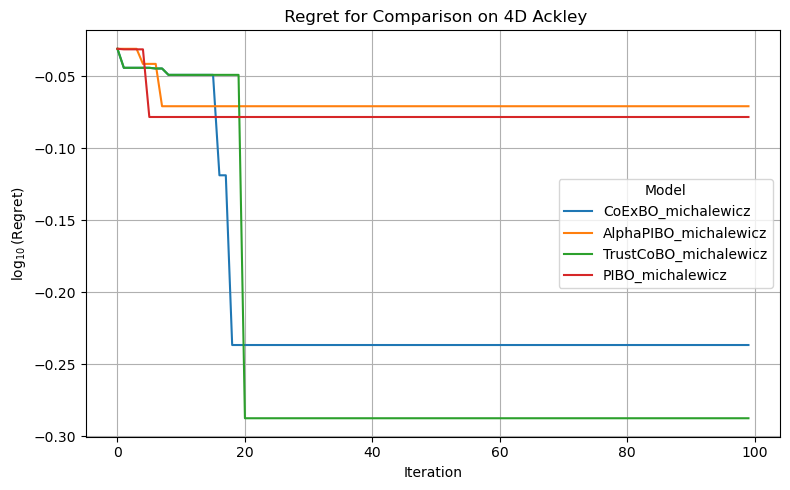

In [41]:
files = [
    "./results/michalewicz/CoExBO_michalewicz.npz",
    "./results/michalewicz/AlphaPIBO_michalewicz.npz",
    "./results/michalewicz/TrustCoBO_michalewicz.npz",
    "./results/michalewicz/PIBO_michalewicz.npz",
]
plot_regrets(files, "Comparison on 4D Ackley")

In [ ]:
def plot_regrets(experiment_filenames, experiment_name):
    """
    Load and plot mean ± 1 std log-regret curves from multiple experiments.

    Args:
        experiment_filenames (List[str]): paths to .npz files, each containing a "log_regrets" array (n_reps, n_iterations).
        experiment_name (str): title to use on the plot.
    """
    plt.figure(figsize=(8, 5))
    
    for fp in experiment_filenames:
        data = np.load(fp)
        log_regrets = data["log_regrets"]  # shape (n_reps, n_iterations)

        # Compute mean and std across repetitions
        mean_log_regret = log_regrets.mean(axis=0)
        std_log_regret = log_regrets.std(axis=0)
        iterations = np.arange(log_regrets.shape[1])

        # Derive a label from the filename
        label = os.path.splitext(os.path.basename(fp))[0]

        # Plot the mean line
        plt.plot(iterations, mean_log_regret, label=label)
        '''
        # Fill between mean ± std
        plt.fill_between(
            iterations,
            mean_log_regret - std_log_regret,
            mean_log_regret + std_log_regret,
            alpha=0.3
        )'''
    
    plt.xlabel("Iteration")
    plt.ylabel(r"$\log_{10}$(Regret)")
    plt.title(f"Regret for {experiment_name}")
    plt.legend(title="Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

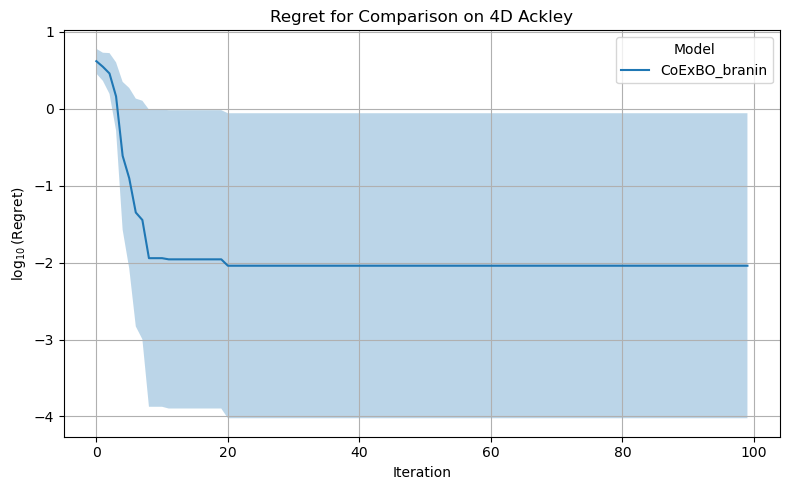

In [12]:
files = [
    "./CoExBO_branin.npz",
    
]
plot_regrets(files, "Comparison on 4D Ackley")

# Runner

In [ ]:
function = 'branin'
define_function(function)
TrustCoBO(function)
AlphaPiBO(function)
PIBO(function)


Starting repetition 1/3


NameError: name 'domain' is not defined

In [ ]:
function = 'holder'
define_function(function)
AlphaPiBO(function)
PIBO(function)
TrustCoBO(function)
CoExBO(function)

In [ ]:
function = 'michalewicz'
define_function(function)
AlphaPiBO(function)
PIBO(function)
TrustCoBO(function)
CoExBO(function)

In [ ]:
function = 'rosenbrod'
define_function(function)
AlphaPiBO(function)
PIBO(function)
TrustCoBO(function)
CoExBO(function)

In [ ]:
function = 'hartmann'
define_function(function)
AlphaPiBO(function)
PIBO(function)
TrustCoBO(function)
CoExBO(function)